In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
df=pd.read_csv("vocal_gender_features_new.csv")

In [3]:
df = df.dropna(axis=1)


In [4]:
df.shape

(16148, 44)

In [5]:
df.drop_duplicates(inplace=True)


In [8]:
df.shape

(15070, 44)

In [9]:
skew_vals = df.skew()
high_skew_cols = skew_vals[skew_vals.abs() > 0.75]
print(high_skew_cols)


mean_spectral_contrast    -0.899611
min_pitch                  4.878715
max_pitch                -13.400446
std_pitch                 -1.434120
spectral_kurtosis          1.478030
mfcc_8_std                 0.989087
dtype: float64


sqrt transformation for midl right skew

square transformation for mild left skew

log trans for high right skew

cube trans for high left skew

In [10]:
df['mfcc_8_std'] = np.sqrt(df['mfcc_8_std'])
df['mean_spectral_contrast'] = df['mean_spectral_contrast'] ** 2
df['min_pitch'] = np.log1p(df['min_pitch'] - df['min_pitch'].min() + 1)
df['spectral_kurtosis'] = np.log1p(df['spectral_kurtosis'] - df['spectral_kurtosis'].min() + 1)
df['max_pitch'] = df['max_pitch'] ** 3
df['std_pitch'] = df['std_pitch'] ** 3


In [11]:
x = df.drop(columns=['label'])
y = df['label']

In [13]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [14]:
scaler = StandardScaler()


In [15]:
y_train.value_counts()

label
1    6889
0    3660
Name: count, dtype: int64

In [16]:
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)


In [19]:
x_train_bal, y_train_bal = smote.fit_resample(x_train_scaled, y_train)


In [48]:
print(pd.Series(y_train_bal).value_counts())

label
0    6889
1    6889
Name: count, dtype: int64


In [20]:
x_train_bal_df = pd.DataFrame(x_train_bal, columns=x_train.columns)


random forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.metrics import classification_report


In [49]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

In [50]:
rf.fit(x_train_bal, y_train_bal)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [59]:
y_pred_rf = rf.predict(x_test_scaled)

acc_rf  = accuracy_score(y_test, y_pred_rf)
# prec_rf = precision_score(y_test, y_pred_rf)
# rec_rf  = recall_score(y_test, y_pred_rf)
# f1_rf   = f1_score(y_test, y_pred_rf)

print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy:",acc_rf)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.99      1.00      0.99      1476

    accuracy                           0.99      2261
   macro avg       0.99      0.99      0.99      2261
weighted avg       0.99      0.99      0.99      2261

[[ 775   10]
 [   6 1470]]
Accuracy: 0.9929234851835471


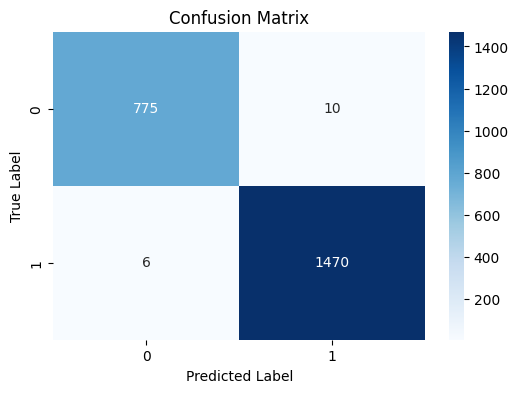

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [27]:
importances = rf.feature_importances_
feature_names_rf = x_train_bal_df.columns

In [28]:
feat_imp = pd.DataFrame({
    "feature": feature_names_rf,
    "importance": importances
}).sort_values(by="importance", ascending=False)

In [29]:
feat_imp.head(20)

,feature,importance
25,mfcc_5_mean,0.165674
4,mean_spectral_contrast,0.106144
22,mfcc_3_std,0.084931
19,mfcc_2_mean,0.073461
3,std_spectral_bandwidth,0.050087
39,mfcc_12_mean,0.047017
17,mfcc_1_mean,0.040221
35,mfcc_10_mean,0.030605
20,mfcc_2_std,0.030567
8,rms_energy,0.030355


SMOTE oversampling was applied to balance the training dataset.
However, performance improvement was marginal compared to class-weight balancing.
This indicates that the original dataset's discriminative features were strong enough that class imbalance did not significantly impact model performance.

SVM

In [30]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True, C=1, gamma='scale', random_state=42)


In [31]:
svm.fit(x_train_bal, y_train_bal)


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [32]:
y_pred_svm = svm.predict(x_test_scaled)


In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))

Accuracy: 0.9995577178239717
Precision: 0.999322951929587
Recall: 1.0
F1 Score: 0.9996613613274636


SVM VALIDATION CHECK

In [34]:
y_pred_svm_val = svm.predict(x_val_scaled)


In [35]:
print("Accuracy:", accuracy_score(y_val, y_pred_svm_val))
print("Precision:", precision_score(y_val, y_pred_svm_val))
print("Recall:", recall_score(y_val, y_pred_svm_val))
print("F1 Score:", f1_score(y_val, y_pred_svm_val))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


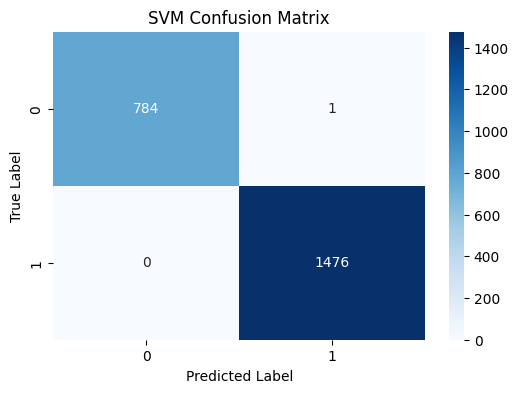

In [36]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM Confusion Matrix")
plt.show()


MLP CLASSIFIER

In [37]:
from sklearn.neural_network import MLPClassifier


In [38]:
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True
)

In [40]:
nn.fit(x_train_bal,y_train_bal)


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(64, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [41]:
y_pred_nn = nn.predict(x_test_scaled)


In [42]:
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1 Score:", f1_score(y_test, y_pred_nn))


Accuracy: 0.9964617425917736
Precision: 0.997289972899729
Recall: 0.997289972899729
F1 Score: 0.997289972899729


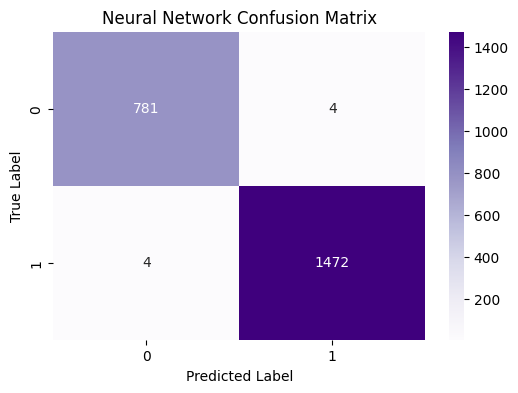

In [43]:

cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Neural Network Confusion Matrix")
plt.show()


NN grid cv

In [45]:
param_grid = {
    'hidden_layer_sizes': [(64,32), (128,64), (32,16)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],  
}

from sklearn.model_selection import GridSearchCV

grid_nn = GridSearchCV(MLPClassifier(max_iter=500, early_stopping=True),
                       param_grid,
                       scoring='accuracy',
                       cv=3)

grid_nn.fit(x_train_bal, y_train_bal)

print("Best Params:", grid_nn.best_params_)
best_nn = grid_nn.best_estimator_


Best Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'solver': 'adam'}


In [46]:
y_pred_nn_tuned = grid_nn.predict(x_test_scaled)


In [47]:
print("Accuracy:", accuracy_score(y_test, y_pred_nn_tuned))
print("Precision:", precision_score(y_test, y_pred_nn_tuned))
print("Recall:", recall_score(y_test, y_pred_nn_tuned))
print("F1 Score:", f1_score(y_test, y_pred_nn_tuned))


Accuracy: 0.9969040247678018
Precision: 0.9979661016949153
Recall: 0.997289972899729
F1 Score: 0.9976279227380549


SMOTE did NOT:

Dramatically improve recall

Dramatically reduce errors

Increase performance beyond SVM

Which means:

original imbalance strategy (class_weight) was already sufficient.